Cleaned column names: ['Timestamp(ms)', 'Temperature(C)', 'PredictedTemperature(C)']
Available columns: ['Timestamp(ms)', 'Temperature(C)', 'PredictedTemperature(C)']
Could not find column 'Temperature(C)'. Using the second column (index 1) instead.


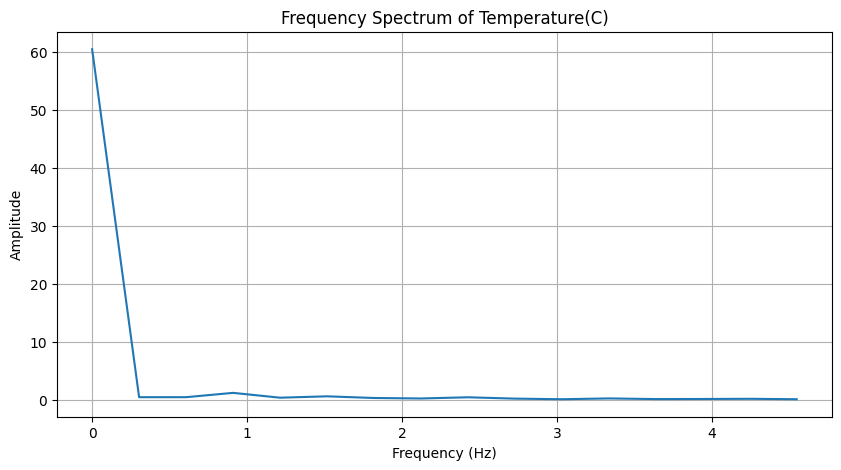

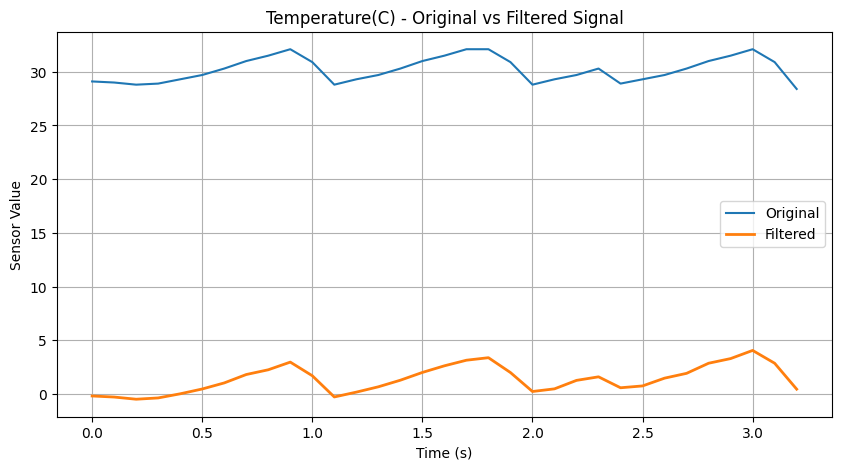

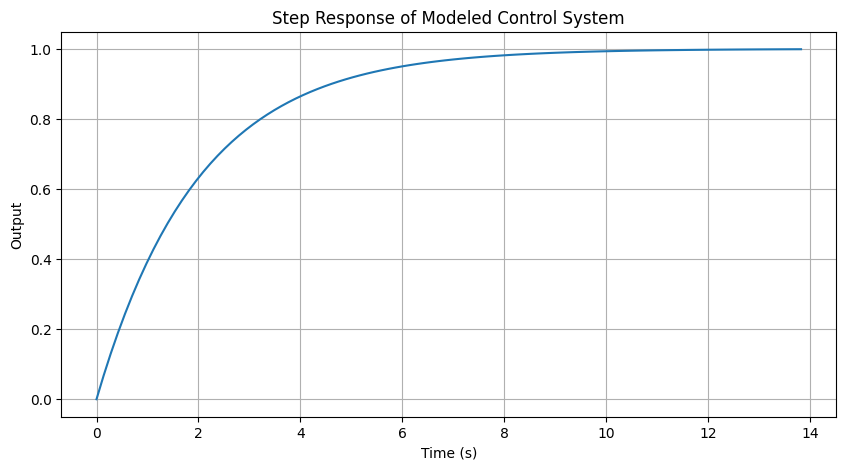

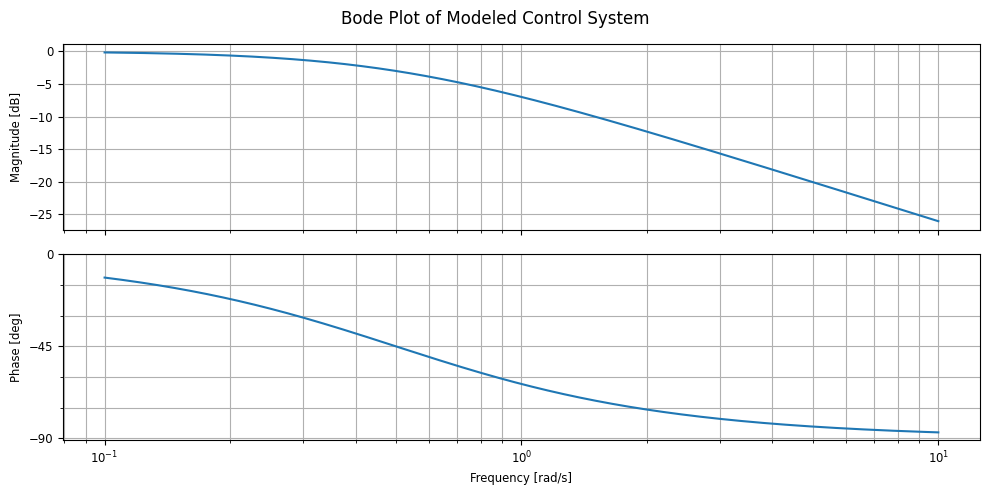


System Poles: [-0.5+0.j]
✅ System is stable.

--- Fourier Analysis Summary ---
Sampling Frequency: 10.00 Hz
Top 5 Dominant Frequencies (Hz): [0.         0.90909091 1.51515152 0.60606061 0.3030303 ]

--- Control System Summary ---
Transfer Function G(s) = 1.0 / (2.0s + 1)
Poles: [-0.5+0.j]


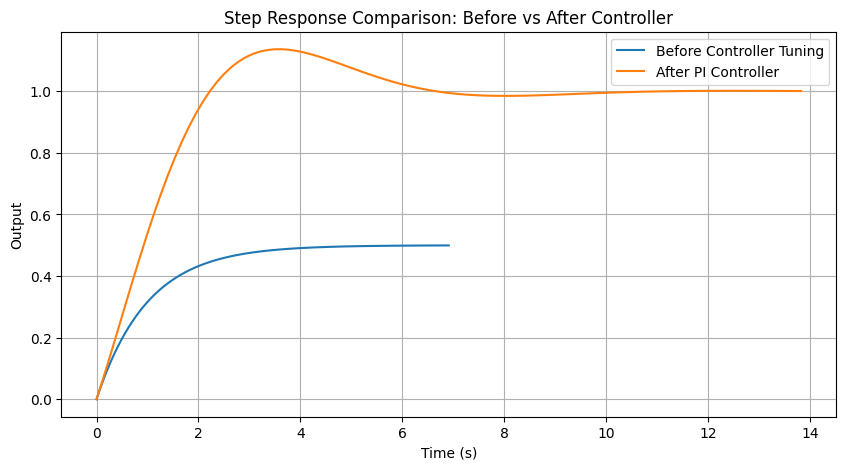

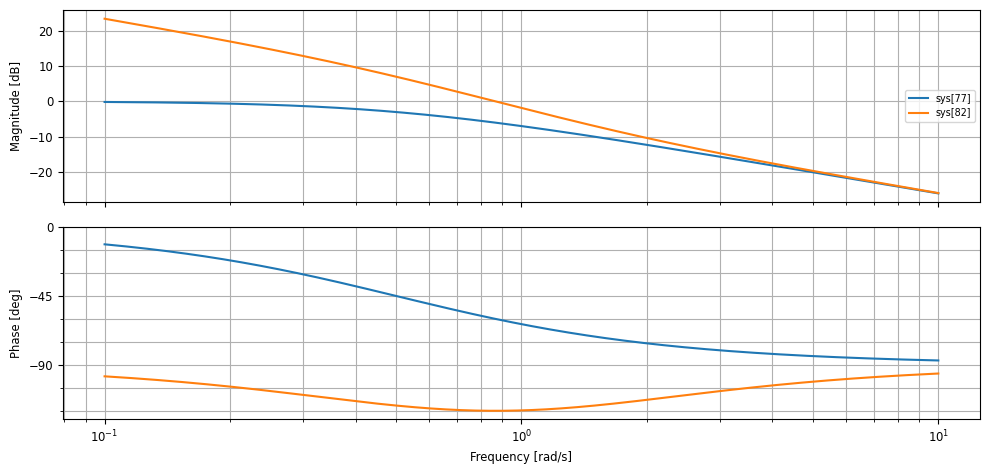


System Poles BEFORE Controller: <bound method TransferFunction.poles of TransferFunction(array([1.]), array([2., 2.]))>
System Poles AFTER PI Controller: <bound method TransferFunction.poles of TransferFunction(array([1. , 1.5]), array([2. , 2. , 1.5]))>
✅ The tuned system is stable.


In [11]:
# LOCKHUB - Mathematical Foundation Enhancement

# Install required packages
!pip install control scipy matplotlib pandas numpy

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt
import control as ctrl

# Load the CSV file
filename = "LockHub_DHT.csv"
data = pd.read_csv(filename)

# Clean up column headers
data.columns = data.columns.str.strip().str.replace('\u202f', '', regex=False).str.replace('\xa0', '', regex=False).str.replace('\ufeff', '', regex=False)

# Print to confirm cleanup
print("Cleaned column names:", data.columns.tolist())

# Assign columns
time_col = 'Timestamp(ms)'
sensor_col = 'Temperature(°C)'

# Column fallback
try:
    time = data[time_col].values / 1000.0
    signal = data[sensor_col].values
except KeyError:
    print("Available columns:", data.columns.tolist())
    if sensor_col not in data.columns:
        sensor_col = data.columns[1]
        print(f"Could not find column '{sensor_col}'. Using the second column (index 1) instead.")
        signal = data.iloc[:, 1].values
    else:
        signal = data[sensor_col].values

# Sampling
desired_fs = 10  # Hz
dt = 1 / desired_fs
fs = desired_fs
time = np.arange(0, len(signal) * dt, dt)

# -----------------------------
# 1. Fourier Series Analysis
# -----------------------------
N = len(signal)
yf = fft(signal)
xf = fftfreq(N, dt)[:N//2]

# Plot frequency spectrum
plt.figure(figsize=(10, 5))
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.title(f"Frequency Spectrum of {sensor_col}")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

# Bandpass filter function
def bandpass_filter(signal, lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    if low >= 1 or high >= 1:
        raise ValueError("Cutoff frequencies too high for sampling rate.")
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Apply bandpass filter
filtered_signal = bandpass_filter(signal, lowcut=0.1, highcut=4.5, fs=fs)

# Plot original vs filtered
plt.figure(figsize=(10, 5))
plt.plot(time, signal, label='Original')
plt.plot(time, filtered_signal, label='Filtered', linewidth=2)
plt.legend()
plt.title(f"{sensor_col} - Original vs Filtered Signal")
plt.xlabel("Time (s)")
plt.ylabel("Sensor Value")
plt.grid()
plt.show()

# -----------------------------
# 2. Laplace Transform Modeling
# -----------------------------
# First-order system: G(s) = K / (τs + 1)
K = 1.0
tau = 2.0
G = ctrl.TransferFunction([K], [tau, 1])

# Step response
t_out, y_out = ctrl.step_response(G)
plt.figure(figsize=(10, 5))
plt.plot(t_out, y_out)
plt.title("Step Response of Modeled Control System")
plt.xlabel("Time (s)")
plt.ylabel("Output")
plt.grid()
plt.show()

# Bode plot
plt.figure(figsize=(10, 5))
ctrl.bode(G, dB=True)
plt.suptitle("Bode Plot of Modeled Control System")
plt.show()

# Stability check
poles = G.poles()
print("\nSystem Poles:", poles)
if np.all(np.real(poles) < 0):
    print("✅ System is stable.")
else:
    print("❌ System is unstable.")

# -----------------------------
# 3. Summary Outputs
# -----------------------------
dominant_freqs = xf[np.argsort(np.abs(yf[:N//2]))[::-1][:5]]
print("\n--- Fourier Analysis Summary ---")
print(f"Sampling Frequency: {fs:.2f} Hz")
print("Top 5 Dominant Frequencies (Hz):", dominant_freqs)

print("\n--- Control System Summary ---")
print(f"Transfer Function G(s) = {K} / ({tau}s + 1)")
print("Poles:", poles)

# -----------------------------
# 4. Control System Tuning & Comparison (PI Controller)
# -----------------------------
# PI controller: Gc(s) = Kp + Ki/s
Kp = 1.0
Ki = 1.5
Gc = ctrl.TransferFunction([Kp, Ki], [1, 0])

# Series connection with system
G_after = ctrl.series(Gc, G)

# Closed-loop systems (unity feedback)
CL_before = ctrl.feedback(G)
CL_after = ctrl.feedback(G_after)

# Step response comparison
t1, y1 = ctrl.step_response(CL_before)
t2, y2 = ctrl.step_response(CL_after)

plt.figure(figsize=(10, 5))
plt.plot(t1, y1, label="Before Controller Tuning")
plt.plot(t2, y2, label="After PI Controller")
plt.title("Step Response Comparison: Before vs After Controller")
plt.xlabel("Time (s)")
plt.ylabel("Output")
plt.grid()
plt.legend()
plt.show()

# Bode comparison
plt.figure(figsize=(10, 5))
ctrl.bode(G, dB=True)
ctrl.bode(G_after, dB=True)
plt.suptitle("Bode Plot Comparison: Before vs After Controller")
plt.show()

# Pole comparison
print("\nSystem Poles BEFORE Controller:", CL_before.poles)
print("System Poles AFTER PI Controller:", CL_after.poles)
if np.all(np.real(CL_after.poles()) < 0):
    print("✅ The tuned system is stable.")
else:
    print("❌ The tuned system is unstable.")
